# RL

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания.**

После того, как заявленные значения совпадут и будут получены работающие модели выполните следующие задания:

1. **Базовая часть (3 балла):** исследуйте влияние параметров `gamma, lr_rate, epsilon` на обучение моделей. Постройте графики.
2. **Опциональная часть (+2 балла):** Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

Зададим гиперпараметры модели

In [1]:
from fontTools.misc.bezierTools import epsilon

epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [2]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q

/content/gym_0_18_0
  Preparing metadata (setup.py) ... done


In [3]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFHFF
FHFFHF
FFFHHF
HFFHHF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [12]:
def choose_action(state, epsilon, Q):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(lr_rate, gamma, state, state2, reward, action, done, Q):
    if done:
        Q[state, action] = Q[state, action] + lr_rate*(reward - Q[state, action])
    else:
        Q[state, action] = Q[state, action] + lr_rate*(reward+ gamma*np.max(Q[state2, :]) - Q[state, action])

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [19]:
from tqdm import tqdm
# Inititalization
np.random.seed(random_seed)

def run_simulation(num_episodes=10000, max_actions=100, epsilon=0.1, gamma=0.8, learning_rate=0.9):
    Q_table = np.zeros((env.observation_space.n, env.action_space.n))

    success_count = 0
    consecutive_wins = []
    first_five_wins = 0
    has_five_wins = False
    rewards_history = []

    for episode in tqdm(range(num_episodes)):
        current_state = env.reset()
        step = 0

        while step < max_actions:
            step += 1

            selected_action = choose_action(current_state, epsilon, Q_table)
            next_state, immediate_reward, is_done, _ = env.step(selected_action)

            if step == max_actions:
                is_done = True

            if immediate_reward == 1:
                success_count += 1
                consecutive_wins.append(1)
                if sum(consecutive_wins) == 5 and len(consecutive_wins) == 5 and not has_five_wins:
                    first_five_wins = episode + 1
                    has_five_wins = True
            elif immediate_reward == 0 and is_done:
                consecutive_wins = []

            learn(learning_rate, gamma, current_state, next_state, immediate_reward, selected_action, is_done, Q_table)
            current_state = next_state

            if is_done:
                rewards_history.append(immediate_reward)
                break

    return success_count, first_five_wins, np.cumsum(rewards_history)/(np.arange(num_episodes)+1)

Вывод ответов при заданных параметрах

In [20]:
successes, first_five_win_episode, _ = run_simulation()
print("Количество побед в серии из 10 000 игр: ", successes)
print("Пять побед подряд впервые было одержано в игре ", first_five_win_episode)

100%|██████████| 10000/10000 [00:07<00:00, 1281.80it/s]

Количество побед в серии из 10 000 игр:  7914
Пять побед подряд впервые было одержано в игре  885


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




100%|██████████| 10000/10000 [00:07<00:00, 1309.56it/s]


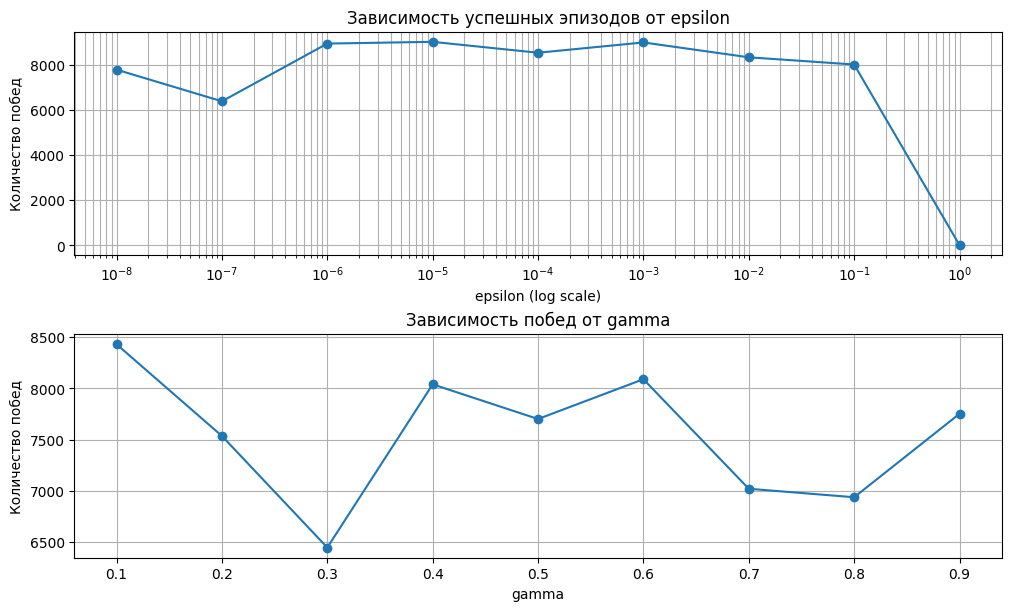

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, figsize=(10, 6), constrained_layout=True)

exploration_values = [10**i for i in range(-8,1)]
success_exploration = [run_simulation(epsilon = eps)[0] for eps in exploration_values]

discount_values = [0.1*i for i in range(1,10)]
success_discount = [run_simulation(gamma = gm)[0] for gm in discount_values]

axes[0].set_title('Зависимость успешных эпизодов от epsilon')
axes[0].set_xlabel('epsilon (log scale)')
axes[0].set_ylabel('Количество побед')
axes[0].semilogx(exploration_values, success_exploration, 'o-')
axes[0].grid(True, which="both", ls="-")

axes[1].set_title('Зависимость побед от gamma')
axes[1].set_xlabel('gamma')
axes[1].set_ylabel('Количество побед')
axes[1].plot(discount_values, success_discount, 'o-')
axes[1].grid(True)

plt.show()

100%|██████████| 10000/10000 [00:07<00:00, 1378.83it/s]


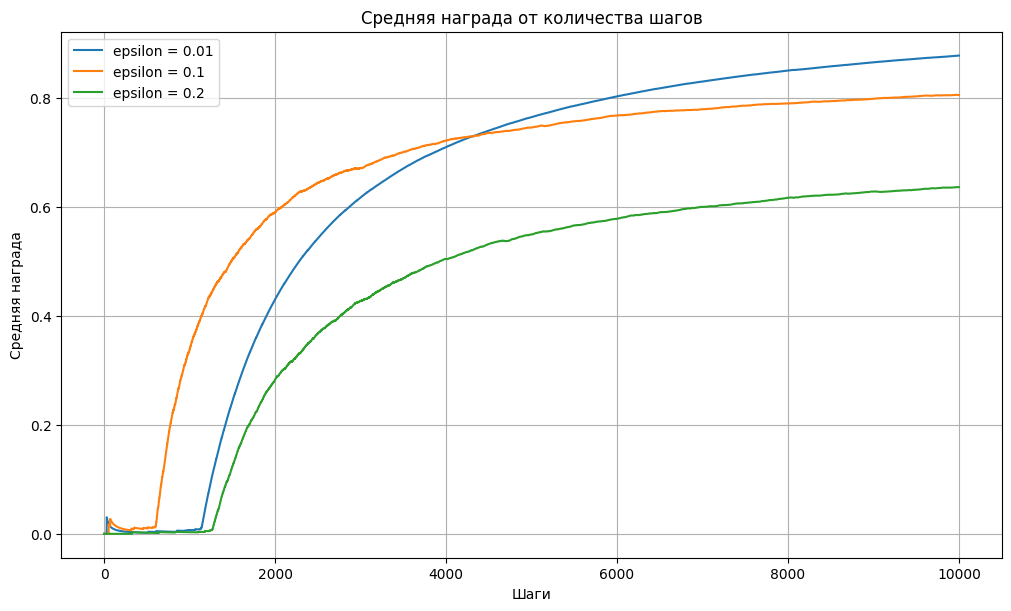

In [26]:
fig, ax = plt.subplots(1, figsize=(10, 6), constrained_layout=True)

steps_values = [i for i in range(10, 100)]

reward_history_001 = run_simulation(epsilon = 0.01)[2]
reward_history_01 = run_simulation(epsilon = 0.1)[2]
reward_history_02 = run_simulation(epsilon = 0.2)[2]

ax.set_title('Средняя награда от количества шагов')
ax.set_xlabel('Шаги')
ax.set_ylabel('Средняя награда')
ax.plot(reward_history_001, label = 'epsilon = 0.01')
ax.plot(reward_history_01, label = 'epsilon = 0.1')
ax.plot(reward_history_02, label = 'epsilon = 0.2')
ax.legend()
ax.grid(True)

# Задача 3

Используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.



In [33]:
def sarsa_learning(discount_factor, learning_rate, current_state, next_state, reward, current_action, next_action, is_done, Q_table):
    if is_done:
        Q_table[current_state, current_action] = Q_table[current_state, current_action] + learning_rate*(reward - Q_table[current_state, current_action])
    else:
        Q_table[current_state, current_action] = Q_table[current_state, current_action] + learning_rate*(reward + discount_factor*Q_table[next_state, next_action] - Q_table[current_state, current_action])

In [42]:
np.random.seed(random_seed)


def run_sarsa_simulation(num_episodes=40000, max_actions=100, epsilon=0.1, gamma=0.8, alpha=0.9,
                    action_selection='e_greedy', temperature=0.5, delta=1.5, init_value=10):
    ucb_counts = {i: 0 for i in range(env.action_space.n)}

    Q_values = np.zeros((env.observation_space.n, env.action_space.n))

    wins = 0
    consecutive_wins = []
    first_five_wins = 0
    five_wins_achieved = False
    reward_history = []

    for episode in tqdm(range(num_episodes)):
        current_state = env.reset()
        step = 0
        if action_selection == 'softmax':
            current_act = select_action_softmax(current_state, Q_values, temp=temperature)
        elif action_selection == 'ucb':
            current_act = select_action_ucb(ucb_counts, current_state, step, Q_values, delta)
        else:
            current_act = choose_action(current_state, epsilon, Q_values)

        while step < max_actions:
            step += 1
            next_state, reward, done, _ = env.step(current_act)

            if action_selection == 'softmax':
                next_act = select_action_softmax(next_state, Q_values, temp=temperature)
            elif action_selection == 'ucb':
                next_act = select_action_ucb(ucb_counts, next_state, step, Q_values, delta)
            else:
                next_act = choose_action(next_state, epsilon, Q_values)

            if step == max_actions:
                done = True

            if action_selection == 'optimize_values':
                update_optimistic_values(gamma, alpha, current_state, next_state, reward, current_act, done, Q_values, init_value)
            else:
                sarsa_learning(gamma, alpha, current_state, next_state, reward, current_act, next_act, done, Q_values)

            current_state = next_state
            current_act = next_act

            if reward == 1 and done:
                wins += 1
                consecutive_wins.append(1)
                if sum(consecutive_wins) == 5 and len(consecutive_wins) == 5 and not five_wins_achieved:
                    first_five_wins = episode + 1
                    five_wins_achieved = True
            elif reward == 0 and done:
                consecutive_wins = []

            if done:
                reward_history.append(reward)
                break

    return wins, first_five_wins, np.cumsum(reward_history) / (np.arange(num_episodes) + 1)

In [36]:
win_total, first_five_win_episode, avg_rewards = run_sarsa_simulation()

print("Количество побед в серии из 40 000 игр: ", win_total)
print("Пять побед подряд впервые было одержано в игре ", first_five_win_episode)

100%|██████████| 40000/40000 [00:36<00:00, 1088.04it/s]

Количество побед в серии из 40 000 игр:  32328
Пять побед подряд впервые было одержано в игре  894


. В результате обучения должны получиться следующие ответы:



*   Количество побед в серии из 40 000 игр:  32328
*   Пять побед подряд впервые было одержано в игре  894

## Другие выборы стратегии (softmax, UCB, Оптимистичные начальные оценки)

In [39]:
# softmax
def select_action_softmax(state, Q, temp=0.5):
    chosen_action = 0
    if np.random.uniform(0, 1) < epsilon:
        chosen_action = np.random.randint(0, env.action_space.n)
    else:
        denominator = sum(np.exp(Q[state, :] / temp))
        actions = range(len(Q[state, :]))
        chosen_action = np.random.choice(actions, p=[np.exp(Q[state, :][x] / temp) / denominator for x in actions])
    return chosen_action


# UCB
def select_action_ucb(action_counts, state, time_step, Q, exploration=1.5):
    selected_action = 0
    state_values = Q[state, :].copy()
    if np.random.uniform(0, 1) < epsilon:
        selected_action = np.random.randint(0, env.action_space.n)
    else:
        ucb_scores = [(state_values[i] + exploration * (np.log(time_step + 1) / action_counts[i]) ** 0.5) if state_values[i] != 0 else 0 for i in range(len(state_values))]
        selected_action = np.random.choice(list(np.argwhere(ucb_scores == np.amax(ucb_scores)).flatten().tolist()))
        action_counts[selected_action] += 1
    return selected_action


# Оптимистичные начальные оценки
def update_optimistic_values(gamma, alpha, state, next_state, reward, action, terminal, Q, optimistic_value=10):
    if terminal:
        Q[state, action] = Q[state, action] + alpha*(reward - Q[state, action])
    elif Q[state, action]==0:
        Q[state, action] = optimistic_value + alpha*(reward + gamma*np.max(Q[next_state, :]) - Q[state, action])
    else:
        Q[state, action] = Q[state, action] + alpha*(reward + gamma*np.max(Q[next_state, :]) - Q[state, action])

100%|██████████| 20000/20000 [00:19<00:00, 1039.44it/s]


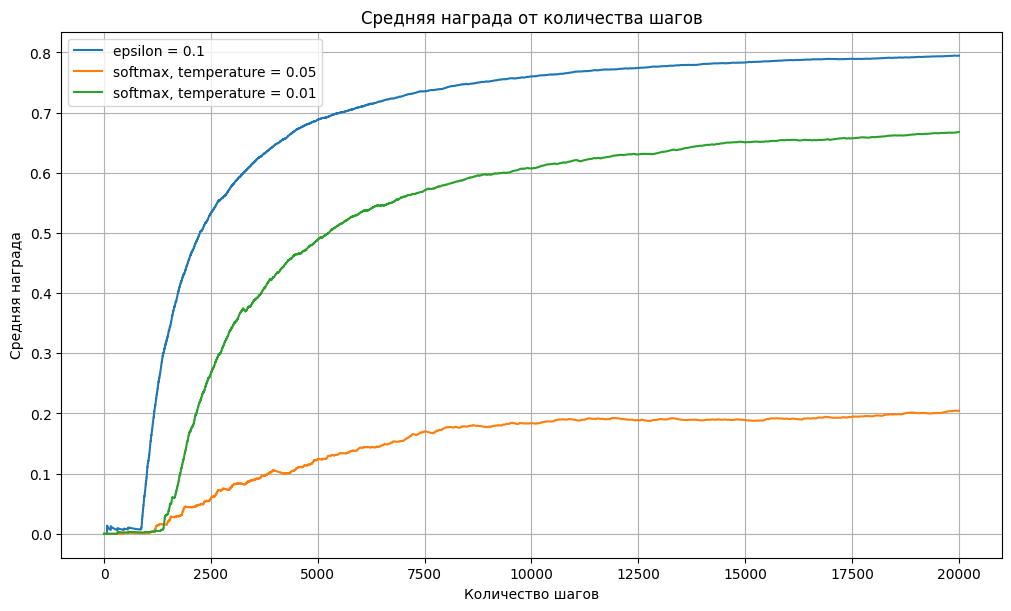

In [44]:
fig, axs = plt.subplots(1, figsize=(10, 6), constrained_layout=True)


win_max_steps_array_001 = run_sarsa_simulation(num_episodes=20000, epsilon = 0.1)[2]

win_max_steps_array_01 = run_sarsa_simulation(num_episodes=20000, action_selection='softmax', temperature = 0.05)[2]

win_max_steps_array_02 = run_sarsa_simulation(num_episodes=20000, action_selection='softmax', temperature = 0.01)[2]


axs.set_title('Средняя награда от количества шагов')
axs.set_xlabel('Количество шагов')
axs.set_ylabel('Средняя награда')
axs.plot(win_max_steps_array_001, label = 'epsilon = 0.1')
axs.plot(win_max_steps_array_01, label = 'softmax, temperature = 0.05')
axs.plot(win_max_steps_array_02, label = 'softmax, temperature = 0.01')
axs.legend()
axs.grid(True)

100%|██████████| 40000/40000 [01:12<00:00, 551.85it/s]


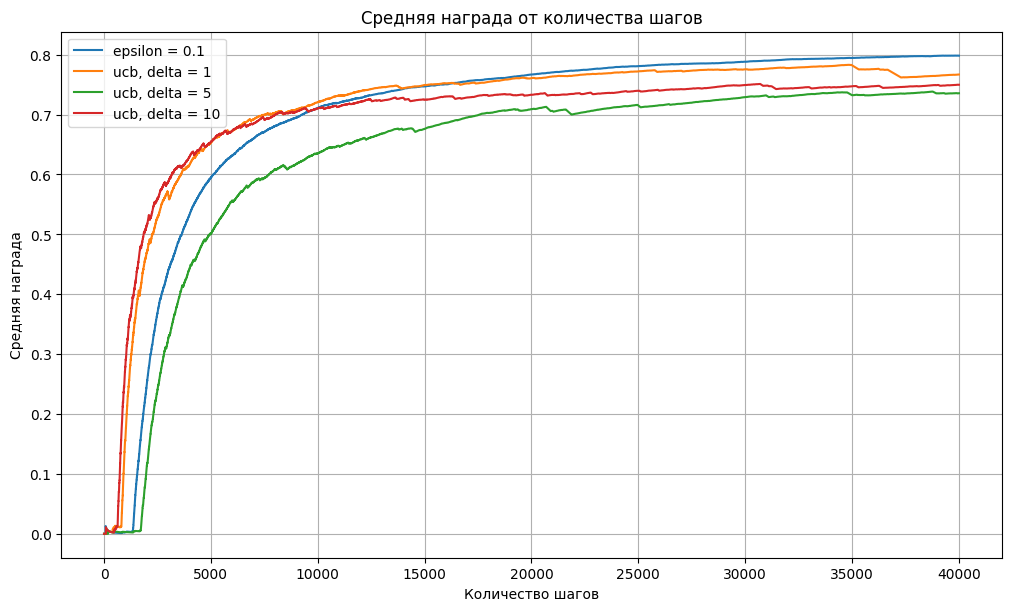

In [50]:
fig, axs = plt.subplots(1, figsize=(10, 6), constrained_layout=True)


win_max_steps_array_001 = run_sarsa_simulation(num_episodes=40000, epsilon = 0.1)[2]

win_max_steps_array_01 = run_sarsa_simulation(num_episodes=40000, action_selection='ucb', delta = 1)[2]

win_max_steps_array_02 = run_sarsa_simulation(num_episodes=40000, action_selection='ucb', delta = 5)[2]

win_max_steps_array_03 = run_sarsa_simulation(num_episodes=40000, action_selection='ucb', delta = 10)[2]


axs.set_title('Средняя награда от количества шагов')
axs.set_xlabel('Количество шагов')
axs.set_ylabel('Средняя награда')
axs.plot(win_max_steps_array_001, label = 'epsilon = 0.1')
axs.plot(win_max_steps_array_01, label = 'ucb, delta = 1')
axs.plot(win_max_steps_array_02, label = 'ucb, delta = 5')
axs.plot(win_max_steps_array_03, label = 'ucb, delta = 10')
axs.legend()
axs.grid(True)

100%|██████████| 40000/40000 [00:39<00:00, 1025.04it/s]


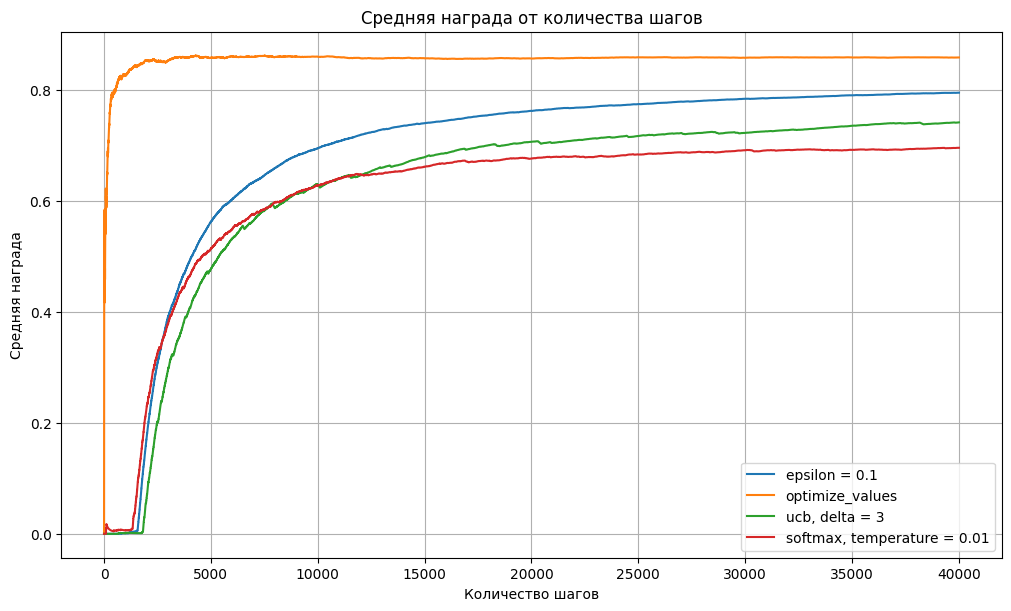

In [49]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, figsize=(10, 6), constrained_layout=True)


win_max_steps_array_001 = run_sarsa_simulation(num_episodes=40000, epsilon = 0.1)[2]

win_max_steps_array_01 = run_sarsa_simulation(num_episodes=40000, action_selection='optimize_values')[2]

win_max_steps_array_02 = run_sarsa_simulation(num_episodes=40000, action_selection='ucb', delta = 3)[2]

win_max_steps_array_03 = run_sarsa_simulation(num_episodes=40000, action_selection='softmax', temperature = 0.01)[2]


axs.set_title('Средняя награда от количества шагов')
axs.set_xlabel('Количество шагов')
axs.set_ylabel('Средняя награда')
axs.plot(win_max_steps_array_001, label = 'epsilon = 0.1')
axs.plot(win_max_steps_array_01, label = 'optimize_values')
axs.plot(win_max_steps_array_02, label = 'ucb, delta = 3')
axs.plot(win_max_steps_array_03, label = 'softmax, temperature = 0.01')
axs.legend()
axs.grid(True)